# RFI Inspection Daily RTP Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import glob
import os
from astropy import units
from copy import deepcopy
from pyuvdata import UVFlag
import matplotlib.colors as colors

%matplotlib inline

In [2]:
# Use environment variables to figure out path to data
JD = os.environ['JULIANDATE']
data_path = os.environ['DATA_PATH']
print(f'JD = {JD}')
print(f'data_path = "{data_path}"')
JD = int(JD)

JD = 2458838
data_path = "/lustre/aoc/projects/hera/jsdillon/H4C_RTP/2458838"


# Show full day of flags

In [3]:
uvf = UVFlag(f'{data_path}/zen.{JD}.total_stage_1_threshold_flags.h5')

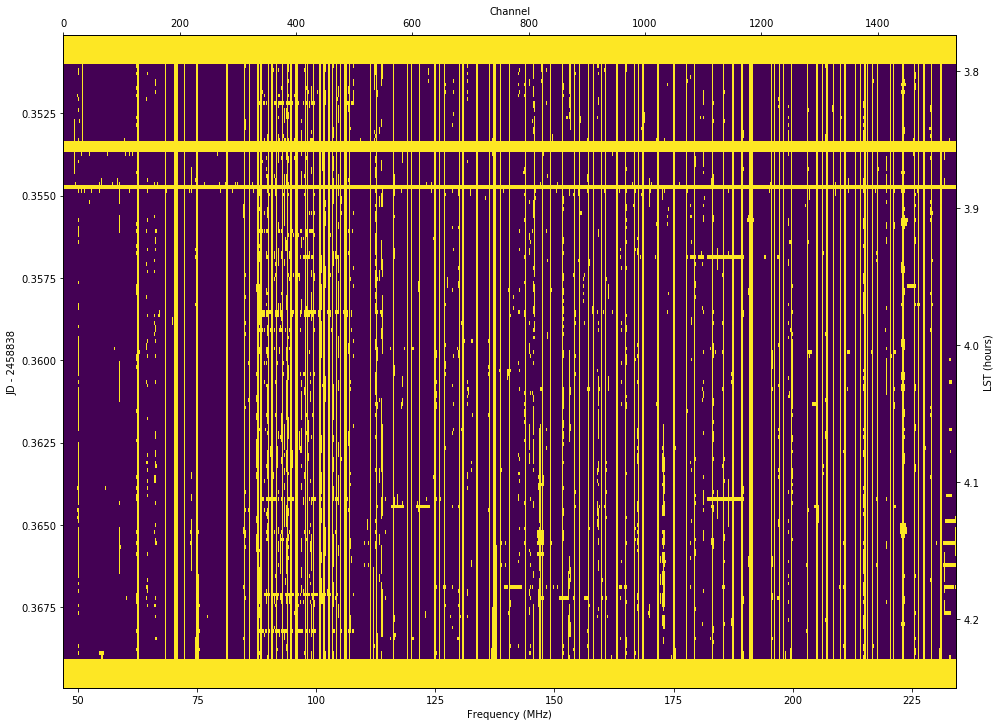

In [4]:
plt.figure(figsize=(16,12))
plt.imshow(uvf.flag_array[:,:,0], aspect='auto',
           extent=[uvf.freq_array[0] / 1e6, uvf.freq_array[-1] / 1e6, 
                   uvf.time_array[-1] - JD, uvf.time_array[0] - JD])
plt.xlabel('Frequency (MHz)')
plt.ylabel(f'JD - {JD}')
ax2 = plt.gca().twinx()
ax2.set_ylim([uvf.lst_array[0] * 12 / np.pi, uvf.lst_array[-1] * 12 / np.pi])
ax2.invert_yaxis()
ax2.set_ylabel('LST (hours)')
ax3 = plt.gca().twiny()
ax3.set_xlim([0, uvf.Nfreqs - 1])
ax3.set_xlabel('Channel');

## Figure 1: RFI Flags
Yellow means flagged, blue is unflagged.

In [5]:
xrfi_dirs = sorted(glob.glob(f'{data_path}/zen.{JD}.?????.stage_1_xrfi'))
print(f'Found {len(xrfi_dirs)} directories containing XRFI intermediate data products.')
files1 = [glob.glob(f'{d}/*combined_metrics1.h5')[0] for d in xrfi_dirs]
print(f'Found {len(files1)} combined round 1 XRFI metrics files.')
files2 = [glob.glob(f'{d}/*combined_metrics2.h5')[0] for d in xrfi_dirs]
print(f'Found {len(files2)} combined round 2 XRFI metrics files.')
uvf1 = UVFlag(files1)
uvf2 = UVFlag(files2)
uvf2.metric_array = np.where(np.isinf(uvf2.metric_array), uvf1.metric_array,
                             uvf2.metric_array)

Found 89 directories containing XRFI intermediate data products.
Found 89 combined round 1 XRFI metrics files.
Found 89 combined round 2 XRFI metrics files.


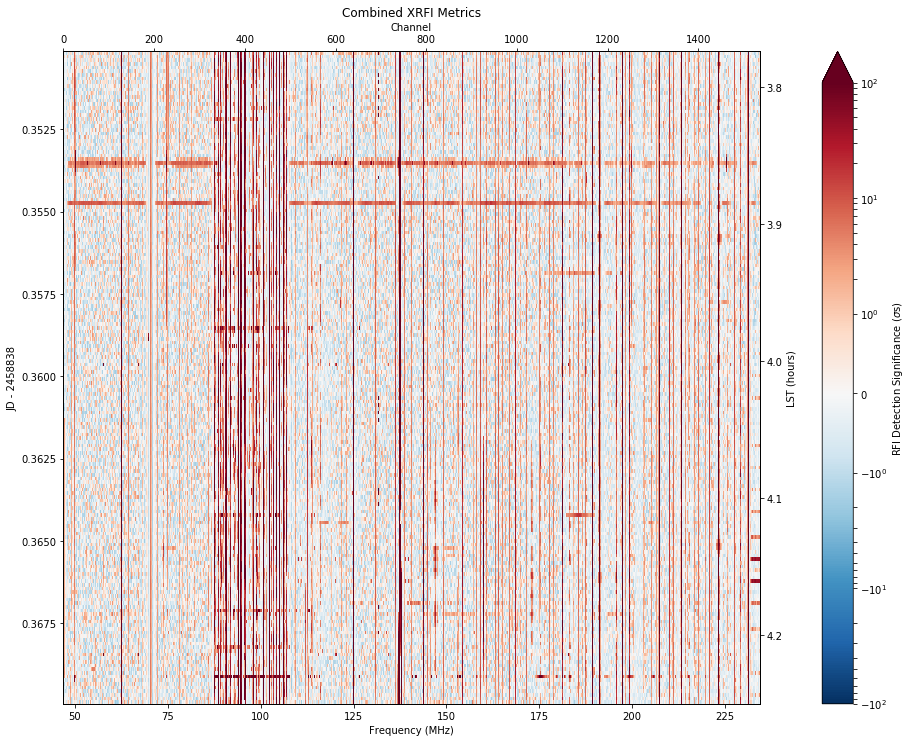

In [6]:
plt.figure(figsize=(16,12))
max_abs = 100
if np.max(uvf2.metric_array) > max_abs:
    extend = 'max'
    if np.min(uvf2.metric_array) < -max_abs:
        extend = 'both'
elif np.min(uvf2.metric_array) < -max_abs:
    extend = 'min'    
else:
    extend = 'neither'

plt.imshow(uvf2.metric_array[:,:,0], aspect='auto', cmap='RdBu_r',
           norm=colors.SymLogNorm(linthresh=1,vmin=-max_abs, vmax=max_abs), 
           extent=[uvf.freq_array[0] / 1e6, uvf.freq_array[-1] / 1e6, 
                   uvf.time_array[-1] - JD, uvf.time_array[0] - JD])
plt.colorbar(pad=.07, extend=extend,
             label='RFI Detection Significance ($\sigma$s)')
plt.title('Combined XRFI Metrics')
plt.xlabel('Frequency (MHz)')
plt.ylabel(f'JD - {JD}')
ax2 = plt.gca().twinx()
ax2.set_ylim([uvf.lst_array[0] * 12 / np.pi, uvf.lst_array[-1] * 12 / np.pi])
ax2.invert_yaxis()
ax2.set_ylabel('LST (hours)')
ax3 = plt.gca().twiny()
ax3.set_xlim([0, uvf.Nfreqs - 1])
ax3.set_xlabel('Channel');

## Figure 2: Combined XRFI Detection Significance
This figure shows round 2 XRFI metrics (mean filter outliers) combined in quadrature. When flagged in round 1 of XRFI, round 1's combined median filter metrics are used instead. 

In [7]:
# Load in the flags from each round of XRFI flagging
round_1_flag_files = [
    glob.glob(os.path.join(xrfi_dir, "*.sum.flags1.h5"))[0]
    for xrfi_dir in xrfi_dirs
]
round_2_flag_files = [f.replace("flags1", "flags2") for f in round_1_flag_files]
thresh_flag_file = glob.glob(os.path.join(data_path, "*.total_stage_1_threshold_flags.h5"))[0]
round_1_uvf = UVFlag(round_1_flag_files)
round_2_uvf = UVFlag(round_2_flag_files)
round_3_uvf = UVFlag(thresh_flag_file)

In [8]:
# Load in the data.
round_1_flags = round_1_uvf.flag_array[...,0]
round_2_flags = round_2_uvf.flag_array[...,0]
round_3_flags = round_3_uvf.flag_array[...,0]

# For plotting convenience.
flags = dict(zip(range(1,4), (round_1_flags, round_2_flags, round_3_flags)))
unique_flags = {
    1: round_1_flags,
    2: round_2_flags & ~round_1_flags,
    3: round_3_flags & ~round_1_flags & ~round_2_flags,
}

# Construct an array that can be color-coded by when flags were introduced.
combined_flags = np.zeros(round_1_flags.shape, dtype=np.float)
for round_, flags_ in unique_flags.items():
    combined_flags[flags_] = round_ / len(unique_flags)
    
# Prepare different plot labels.
flag_labels = (
    "Flagged in Autos",
    "Flagged in Autos + Cross",
    "Flagged in Thresholding",
)
cbar_ticklabels = ("Unflagged",) + tuple(
    "in\n".join(flag_label.split("in "))
    for flag_label in flag_labels
)

# Prepare a colormap.
cmap = plt.cm.colors.ListedColormap(
    ["slategray", "darkturquoise", "plum", "lemonchiffon"]
)

# Useful plot metadata.
lsts = np.unique(round_3_uvf.lst_array)
times = np.unique(round_3_uvf.time_array)
freqs = np.unique(round_3_uvf.freq_array)
chans = np.arange(freqs.size)
lsts_hr = lsts * units.day.to("hr") * units.rad.to("cycle")
freqs_MHz = freqs / 1e6
plot_times = times - float(JD)
extent = (freqs_MHz[0], freqs_MHz[-1], plot_times[-1], plot_times[0])

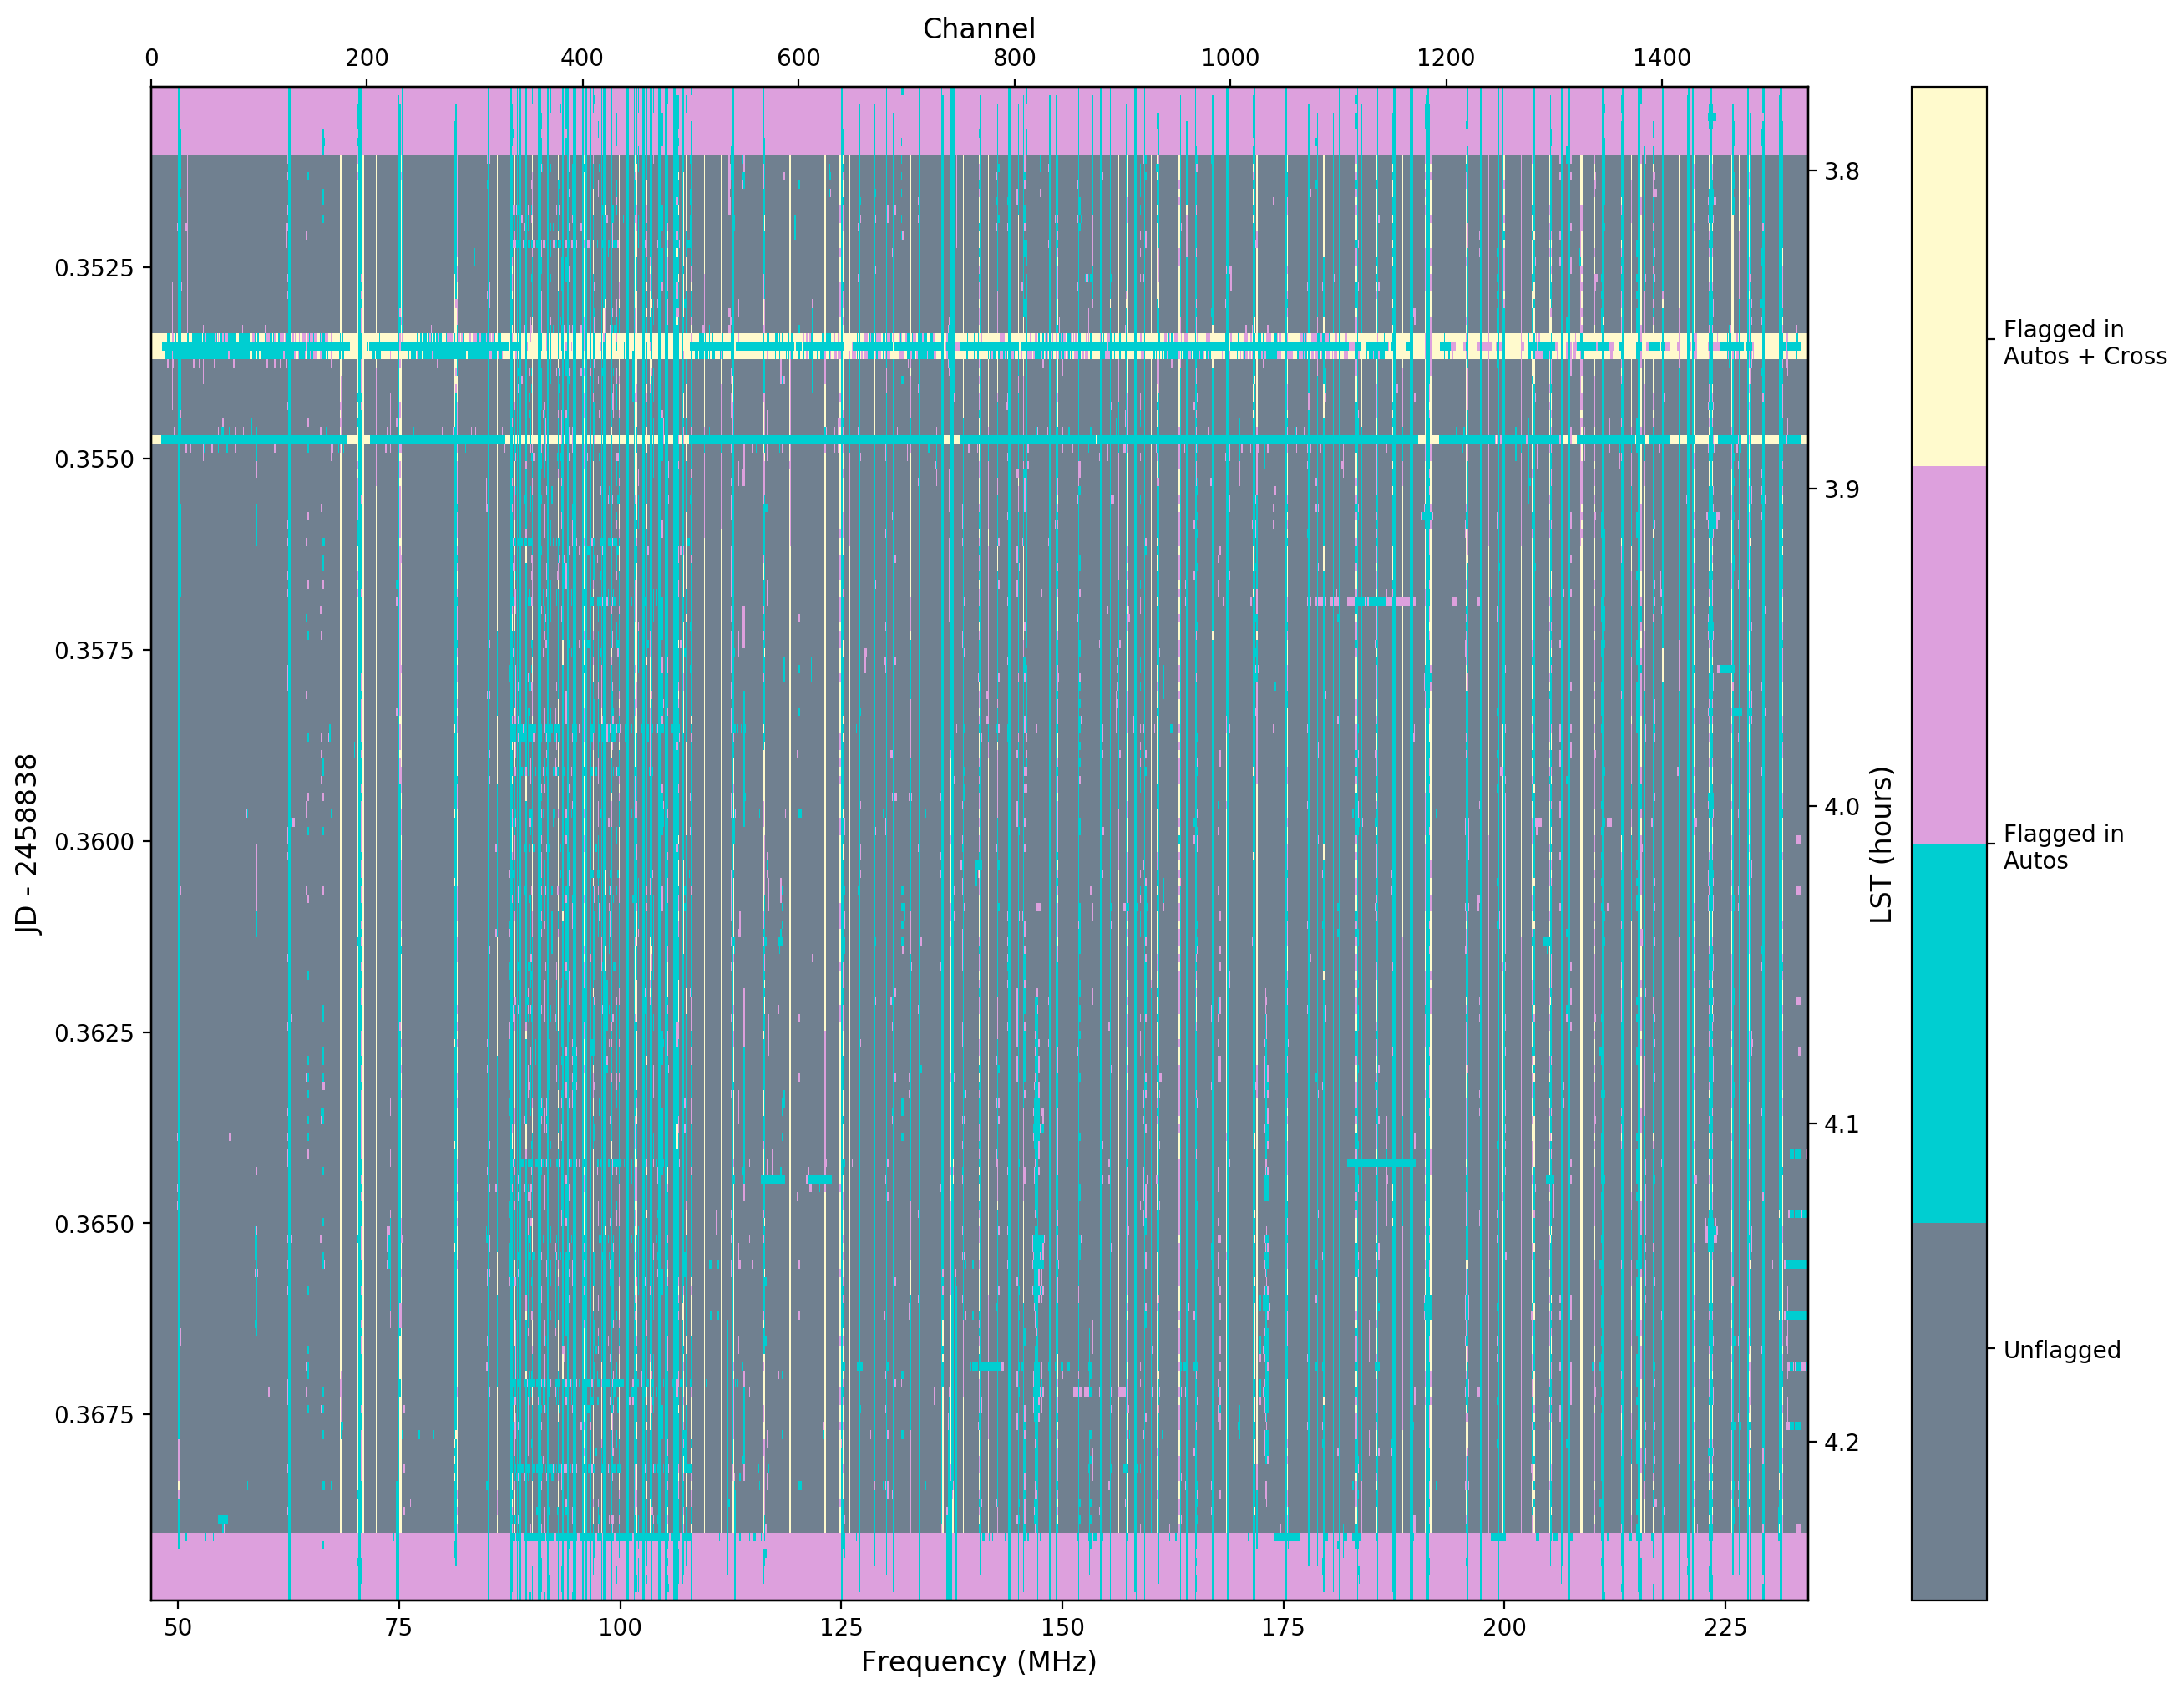

In [9]:
# Make a waterfall showing different flagging products.
fig = plt.figure(figsize=(16,12), dpi=200)
ax = fig.add_subplot(111)
ax.set_xlabel("Frequency (MHz)", fontsize=12)
ax.set_ylabel(f"JD - {JD}", fontsize=12)
ax.set_xlim(*extent[:2])
ax.set_ylim(*extent[2:])
cax = ax.imshow(
    combined_flags,
    aspect="auto",
    extent=extent,
    interpolation='none',
    cmap=cmap,
)

# Add labels on the top and right axes.
twinx = ax.twinx()
twiny = ax.twiny()
twinx.set_ylabel("LST (hours)", fontsize=12)
twinx.set_ylim(lsts_hr.max(), lsts_hr.min())
twiny.set_xlabel("Channel", fontsize=12)
twiny.set_xlim(chans.min(), chans.max())

# Configure the colorbar so that labels are at the center of each section.
cbar = fig.colorbar(cax)
cbar_ticks = np.linspace(combined_flags.min(), combined_flags.max(), len(flags) + 1)
cbar_ticks = 0.5 * (cbar_ticks[1:] + cbar_ticks[:-1])
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticklabels);

## Figure 3: Flag Evolution
This figure shows how the flags are built at each step in the initial XRFI flagging pipeline. Note that the completely flagged sections at the beginning and end of the night are expected. Main thing to look out for is if there are channels which are highly flagged after the second round of flagging but have not been completely flagged after day thresholding.

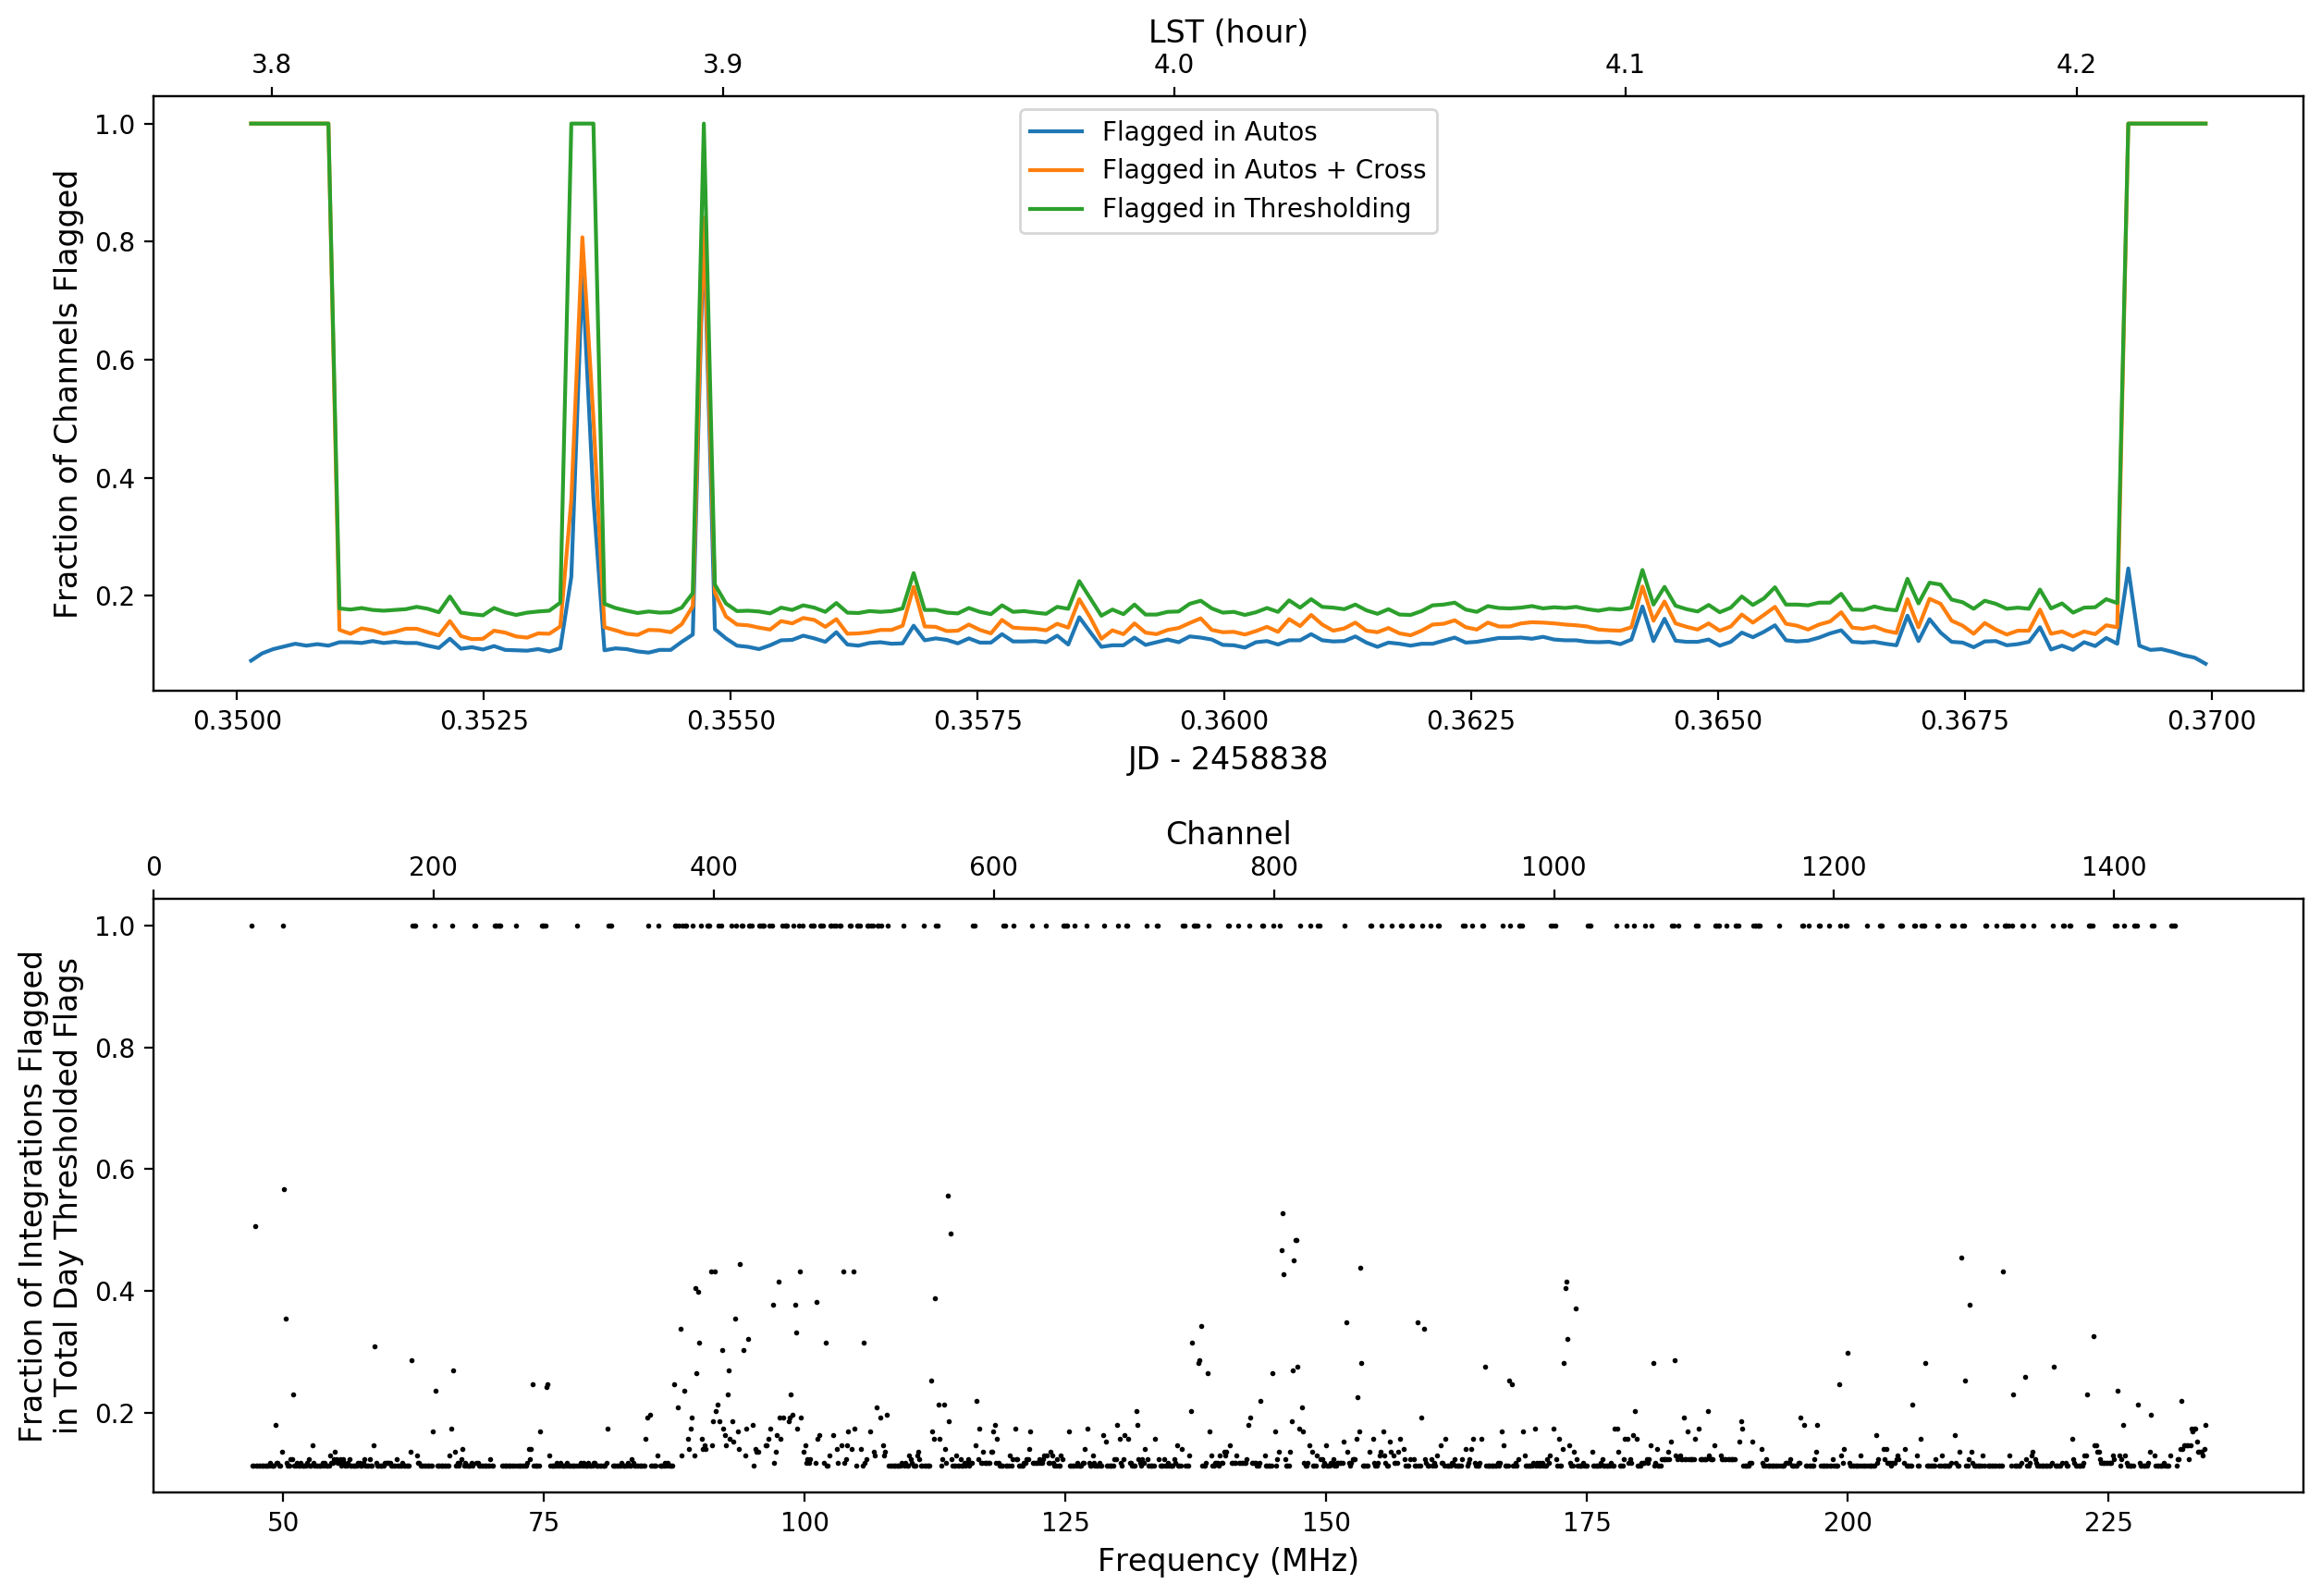

In [10]:
# Collapse the flags along each axis and plot the result.
fig = plt.figure(figsize=(15,10), dpi=200)
axes = fig.subplots(2, gridspec_kw={"hspace": 0.35})
twin_axes = [ax.twiny() for ax in axes]

# Set the plot labels.
axes[0].set_xlabel(f"JD - {JD}", fontsize=12)
axes[0].set_ylabel("Fraction of Channels Flagged", fontsize=12)
axes[1].set_xlabel("Frequency (MHz)", fontsize=12)
axes[1].set_ylabel(
    "Fraction of Integrations Flagged\nin Total Day Thresholded Flags", fontsize=12
)
twin_axes[0].set_xlabel("LST (hour)", fontsize=12)
twin_axes[0].set_xlim(lsts_hr[0], lsts_hr[-1])
twin_axes[1].set_xlabel("Channel", fontsize=12)
twin_axes[1].set_xlim(chans.min(), chans.max())

# Plot the channel occupancy as a function of time.
for label, flag_array in zip(flag_labels, flags.values()):
    axes[0].plot(plot_times, flag_array.astype(np.float).mean(axis=1), label=label)

# Plot the flagging fraction as a function of frequency.
axes[1].plot(
    freqs_MHz, round_3_flags.astype(np.float).mean(axis=0), color="k", ms=1, lw=0, marker="o"
)
    
axes[0].legend();

## Figure 4: Flagging Occupancies
The top plot shows the fraction of channels flagged at each integration for each set of flags. The bottom plot shows the fraction of integrations flagged as a function of frequency for the total thresholded flags.

# Metadata

In [11]:
from hera_qm import version
print(version.construct_version_info())

{'version': '1.0', 'git_origin': 'git@github.com:HERA-Team/hera_qm.git', 'git_hash': '4f54c6857caf4984e4aa70c181c28ccd9c7cc053', 'git_description': 'v1.1-201-g4f54c68', 'git_branch': 'master'}
